In [1]:
import graphlab
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix

%matplotlib inline

'''Check GraphLab Create version'''
from distutils.version import StrictVersion
assert (StrictVersion(graphlab.version) >= StrictVersion('1.8.5')), 'GraphLab Create must be version 1.8.5 or later.'

[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1541354944.log
INFO:graphlab.cython.cy_server:GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1541354944.log


This non-commercial license of GraphLab Create for academic use is assigned to bernardo.ronquillo@gmail.com and will expire on May 11, 2019.


## 1. Load data, extract features

In [2]:
wiki = graphlab.SFrame('people_wiki.gl/')

In [3]:
wiki['tf_idf'] = graphlab.text_analytics.tf_idf(wiki['text'])

In [4]:
wiki.shape

(59071, 4)

### def sframe_to_scipy
We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if you'd like, you may skip the next block and treat the function as a black box.

In [5]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert x[column_name].dtype() == dict, \
        'The chosen column must be dict type, representing sparse data.'
        
    # Create triples of (row_id, feature_id, count).
    # 1. Add a row number.
    x = x.add_row_number()
    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])

    # Map words into integers using a OneHotEncoder feature transformation.
    f = graphlab.feature_engineering.OneHotEncoder(features=['feature'])
    # 1. Fit the transformer using the above data.
    f.fit(x)
    # 2. The transform takes 'feature' column and adds a new column 'feature_encoding'.
    x = f.transform(x)
    # 3. Get the feature mapping.
    mapping = f['feature_encoding']
    # 4. Get the feature id to use for each key.
    x['feature_id'] = x['encoded_features'].dict_keys().apply(lambda x: x[0])

    # Create numpy arrays that contain the data for the sparse matrix.
    i = np.array(x['id'])
    j = np.array(x['feature_id'])
    v = np.array(x['value'])
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1

    # Create a sparse matrix.
    mat = csr_matrix((v, (i, j)), shape=(width, height))

    return mat, mapping

In [6]:
tf_idf, map_index_to_word = sframe_to_scipy(wiki, 'tf_idf')

In [7]:
tf_idf

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

## 2. Normalize all vectors

\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance.

In [8]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## 3. Implement k-means

### 3.1 Define initial centroids
#### def get_initial_centroids

In [9]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

### 3.2 Assigning clusters

In [10]:
from sklearn.metrics import pairwise_distances

#### def assign_clusters

In [11]:
def assign_clusters(data, centroids):
    n_points = np.size(data,0)
    cluster_assignment = np.empty((n_points,1))

    # Compute distances between each data point and the set of centroids:
    # Fill in the blank (RHS only)
    distances_from_centroids = pairwise_distances(data,centroids, metric='euclidean')
    
    # Compute cluster assignments for each data point:
    # Fill in the blank (RHS only)
    # cluster_assignment = ...
    for i in range (n_points):
        point = data[i-1,:]
        index_min = np.argmin(distances_from_centroids[i-1,:])
        cluster_assignment.itemset((i-1,0),index_min)

    cc = np.transpose(cluster_assignment)
    cluster_assignment = np.ndarray.flatten(cc)
    cluster_assignment = cluster_assignment.astype(int)
    
    return cluster_assignment

First, initialize three centroids with the first 3 rows of tf_idf and select the number of document to consider:

In [12]:
k = 3
dist_centroids = tf_idf[0:k]

n_points = len(wiki)  # Número de registros (puntos) del dataset 'people_wiki'
tf_idf = tf_idf[0:n_points,:] # tf-idf de los documentos

 Then, compute distances from each of the centroids to all data points in tf_idf:

In [13]:
distances = pairwise_distances(tf_idf,dist_centroids, metric='euclidean')
print "dist_centroids ---> ", dist_centroids.shape, "\ndistances -> ", distances.shape # -------------------------
print "tf_idf ----> ", tf_idf.shape
######## Inicializar centroides aleatoriamente
######## dist_centroids = get_initial_centroids(tf_idf, k, seed=None)

dist_centroids --->  (3, 547979) 
distances ->  (59071, 3)
tf_idf ---->  (59071, 547979)


Finally, use these distance calculations to compute cluster assignments and assign them to `cluster_assignment`:

In [14]:
cluster_assignment = assign_clusters(tf_idf, dist_centroids)

In [15]:
print cluster_assignment.shape, cluster_assignment

(59071,) [0 1 2 ..., 0 0 0]


### 3.3 Revise location of centroids
#### def revise_centroids

In [16]:
def revise_centroids(data, k, cluster_assignment):
    new_centroids = []
    for i in xrange(k):
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i]
        # Compute the mean of the data points. Fill in the blank (RHS only)
        centroid = member_data_points.mean(axis=0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

In [17]:
dist_centroids_prev = dist_centroids
dist_centroids = revise_centroids(tf_idf, k, cluster_assignment)

In [18]:
print dist_centroids_prev[:,0:4]

In [19]:
print dist_centroids[:,0:4]

[[  0.00000000e+00   0.00000000e+00   5.95761785e-06   0.00000000e+00]
 [  1.41882365e-05   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   3.80733353e-06   0.00000000e+00   1.96743377e-05]]


### 3.4 Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster assignments and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster assignments stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

#### def compute_heterogeneity

In [20]:
def compute_heterogeneity(data, k, centroids, cluster_assignment):
    
    heterogeneity = 0.0
    for i in xrange(k):
        
        # Select all data points that belong to cluster i. Fill in the blank (RHS only)
        member_data_points = data[cluster_assignment==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points (RHS only)
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

## 3.5 K-means algorithm

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 3.2 and 3.3/3.4
* Tracks convergence metrics
* Stops if either no assignment changed or we reach a certain number of iterations.

In [21]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_assignment = None
    
    for itr in xrange(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster assignments using nearest centroids
        # ASSIGN POINTS TO CLUSTERS
        cluster_assignment = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        # COMPUTE REVISED CENTROIDS
        centroids = revise_centroids(data, k, cluster_assignment)
            
        # Check for convergence: if none of the assignments changed, stop
        if prev_cluster_assignment is not None and \
          (prev_cluster_assignment==cluster_assignment).all():
            break
        
        # Print number of new assignments 
        if prev_cluster_assignment is not None:
            num_changed = np.sum(prev_cluster_assignment!=cluster_assignment)
            if verbose:
                print('    {0:5d} elements changed their cluster assignment.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            # COMPUTE HETEROGENEITY
            score = compute_heterogeneity(data, k, centroids, cluster_assignment)
            record_heterogeneity.append(score)
        
        prev_cluster_assignment = cluster_assignment[:]
        
    return centroids, cluster_assignment

We can use the above function to plot the convergence metric across iterations:

In [22]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

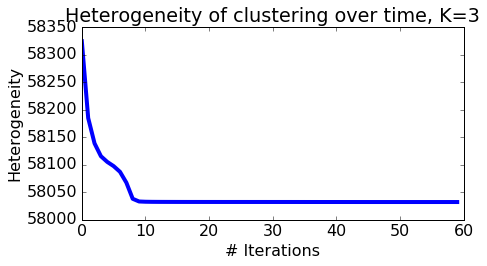

In [23]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_assignment = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)